In [52]:
#load data science libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import datetime
import time
import json
import requests
import warnings
warnings.filterwarnings('ignore')

In [53]:
#import forecastdemand_nsw.parquet
df_fd = pd.read_parquet('../data/NSW/forecastdemand_nsw.parquet')


#drop the 	PREDISPATCHSEQNO, REGIONID and LASTCHANGED columns
df_fd.drop(['PREDISPATCHSEQNO', 'REGIONID', 'LASTCHANGED'], axis=1, inplace=True)

#order by LASTCHANGED
df_fd = df_fd.sort_values(by='DATETIME')

#show the head and tail of the data
print(df_fd.head())
print(df_fd.tail())

    PERIODID  FORECASTDEMAND             DATETIME
0         71         7832.04  2010-01-01 00:00:00
51        20         7819.50  2010-01-01 00:00:00
50        21         7819.89  2010-01-01 00:00:00
49        22         7817.50  2010-01-01 00:00:00
48        23         7808.85  2010-01-01 00:00:00
          PERIODID  FORECASTDEMAND             DATETIME
10905968        51         6934.59  2021-03-18 00:00:00
10905967        52         6936.11  2021-03-18 00:00:00
10905966        53         6930.46  2021-03-18 00:00:00
10905982        37         6946.14  2021-03-18 00:00:00
10906018         1         7126.37  2021-03-18 00:00:00


In [54]:
#change the DATETIME column to datetime
df_fd['DATETIME'] = pd.to_datetime(df_fd['DATETIME'])

#inspect the data in df_fd
print(df_fd.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10906019 entries, 0 to 10906018
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   PERIODID        int64         
 1   FORECASTDEMAND  float64       
 2   DATETIME        datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 332.8 MB
None


In [55]:
#check for missing values
print(df_fd.isnull().sum())

#no values need to be removed or filled in

PERIODID          0
FORECASTDEMAND    0
DATETIME          0
dtype: int64


In [56]:
#import totaldemand_nsw.csv
df_td = pd.read_csv('../data/NSW/totaldemand_nsw.csv')

#drop the REGIONID column
df_td.drop(['REGIONID'], axis=1, inplace=True)

#change DATETIME to datetime format with dayfirst=True
df_td['DATETIME'] = pd.to_datetime(df_td['DATETIME'], dayfirst=True)

#change the DATETIME column to datetime
df_td['DATETIME'] = pd.to_datetime(df_td['DATETIME'])

#inspect the data in df_td
print(df_td.head())


             DATETIME  TOTALDEMAND
0 2010-01-01 00:00:00      8038.00
1 2010-01-01 00:30:00      7809.31
2 2010-01-01 01:00:00      7483.69
3 2010-01-01 01:30:00      7117.23
4 2010-01-01 02:00:00      6812.03


In [57]:
#check for missing values in df_td
print(df_td.isnull().sum())

#no values need to be removed or filled in

DATETIME       0
TOTALDEMAND    0
dtype: int64


In [109]:
#create a join on the DATETIME column
df = pd.merge(df_fd, df_td, on='DATETIME')

#inspect the data in df
print(df.head())


   PERIODID  FORECASTDEMAND   DATETIME  TOTALDEMAND
0        71         7832.04 2010-01-01       8038.0
1        20         7819.50 2010-01-01       8038.0
2        21         7819.89 2010-01-01       8038.0
3        22         7817.50 2010-01-01       8038.0
4        23         7808.85 2010-01-01       8038.0


In [59]:
#compare the size of df_fd, df_td and df
print(df_fd.shape)
print(df_td.shape)
print(df.shape)


(10906019, 3)
(196513, 2)
(10906019, 4)


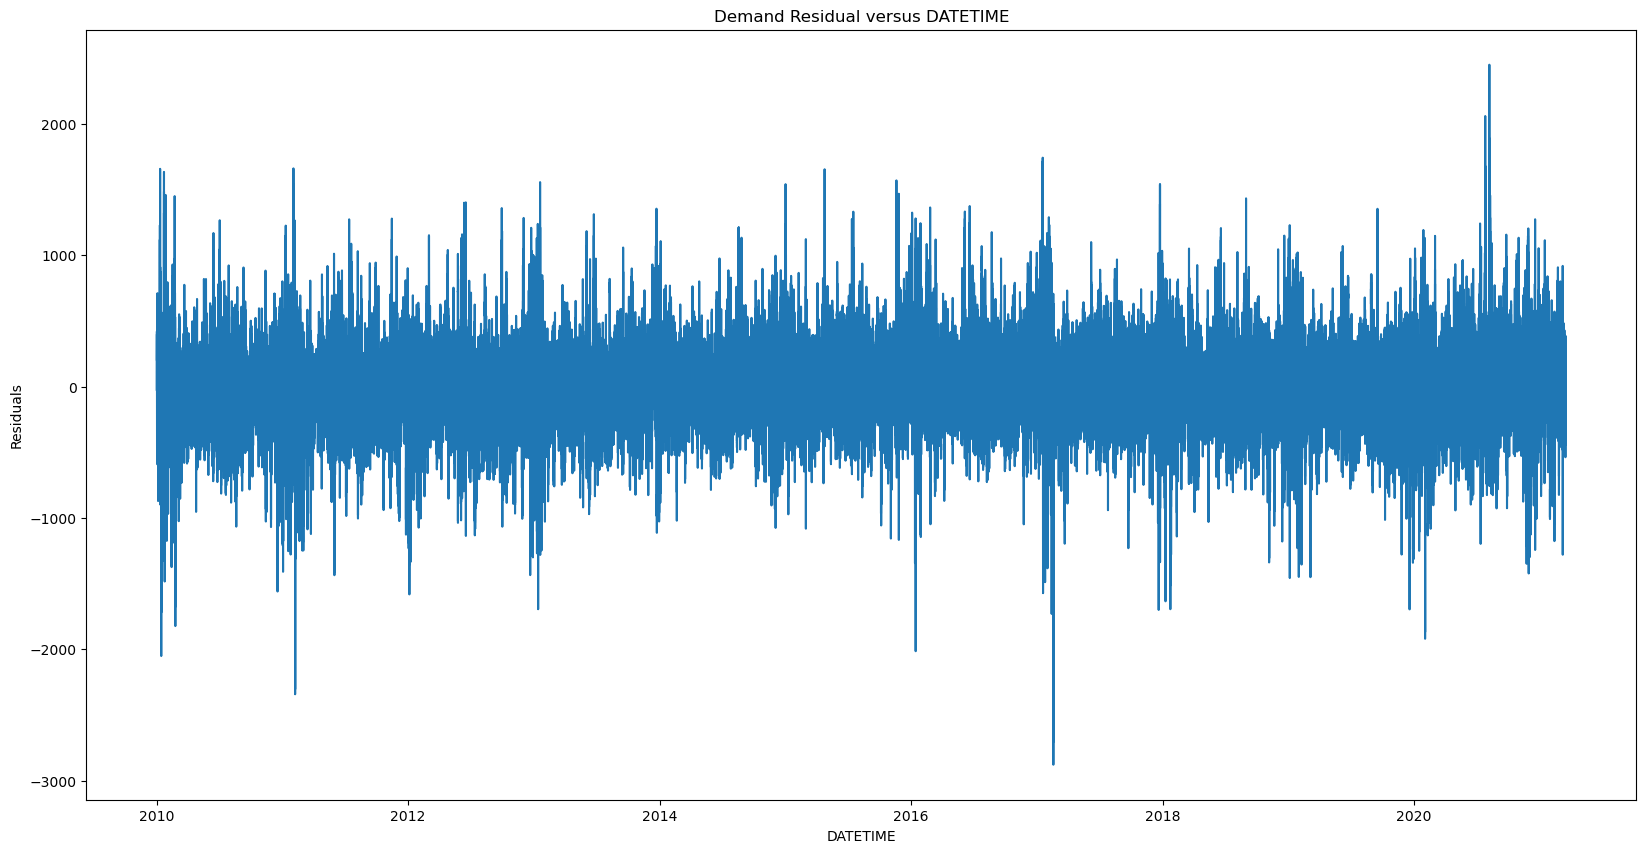

the RMSE of the residuals is:  224.7631516948343


In [60]:
#graph the (TOTALDEMAND - FORECASTDEMAND) versus DATETIME
plt.figure(figsize=(20,10))
plt.plot(df['DATETIME'], df['TOTALDEMAND'] - df['FORECASTDEMAND'])
plt.xlabel('DATETIME')
plt.ylabel('Residuals')
plt.title('Demand Residual versus DATETIME')
plt.show()

#print the RMSE of the residuals
demandRMSE = (np.sqrt(np.mean((df['TOTALDEMAND'] - df['FORECASTDEMAND'])**2)))
print("the RMSE of the residuals is: ", demandRMSE)      


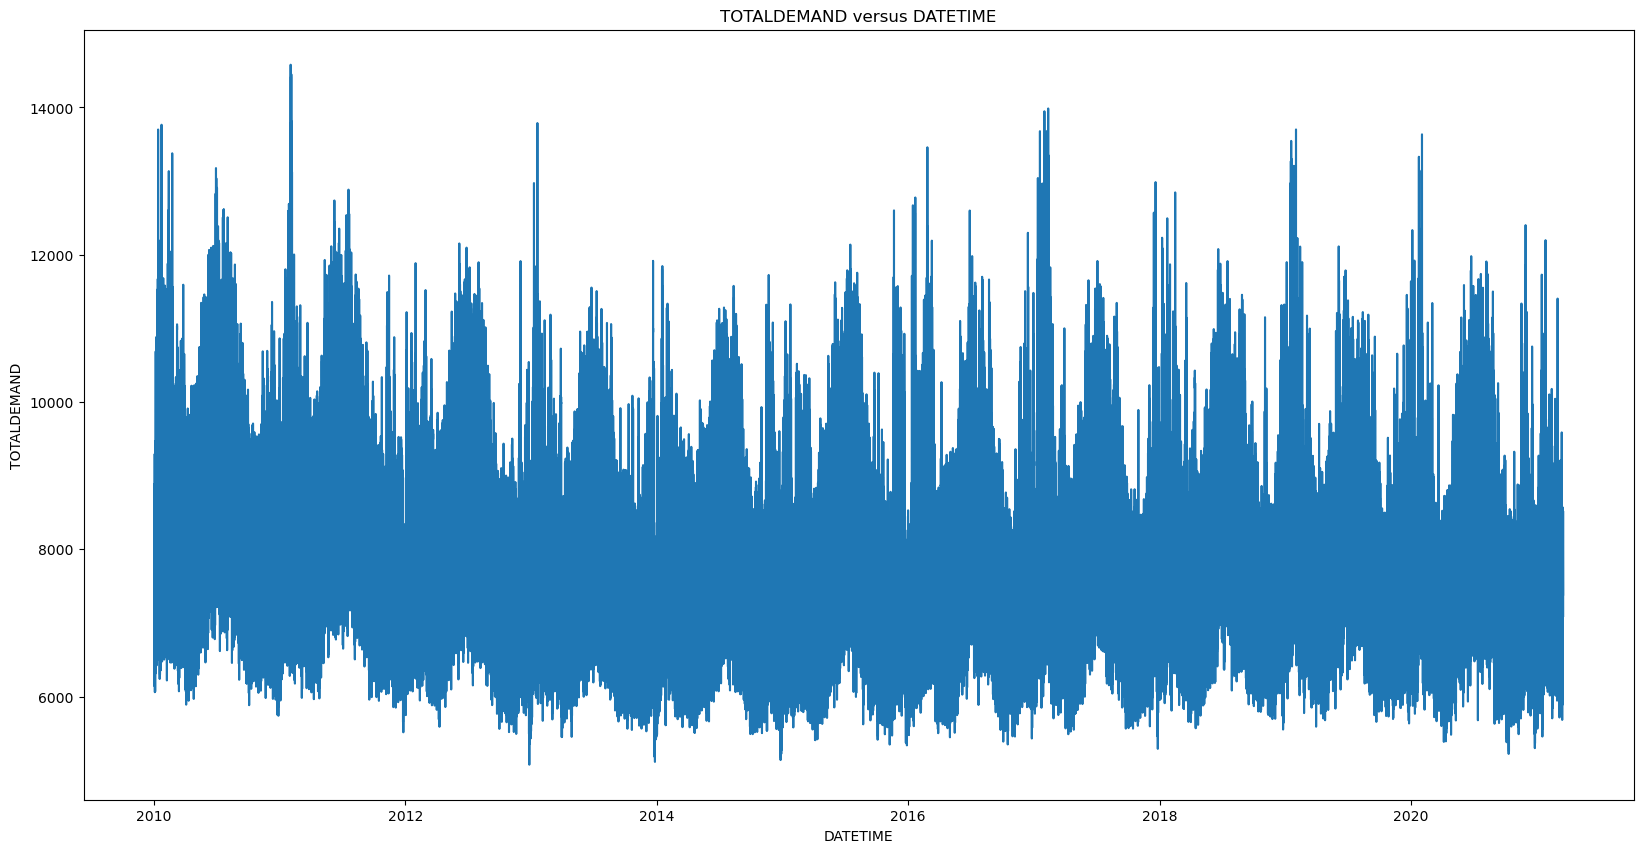

In [61]:
#graph the TOTALDEMAND versus DATETIME
plt.figure(figsize=(20,10))
plt.plot(df['DATETIME'], df['TOTALDEMAND'])
plt.xlabel('DATETIME')
plt.ylabel('TOTALDEMAND')
plt.title('TOTALDEMAND versus DATETIME')
plt.show()


         DATE  FORECASTDEMAND  TOTALDEMAND
0  2010-01-01     7748.111603  7825.836389
1  2010-01-02     7765.116295  7980.974501
2  2010-01-03     7462.384786  7367.493724
3  2010-01-04     8467.411400  8121.602613
4  2010-01-05     8784.750420  8721.738318


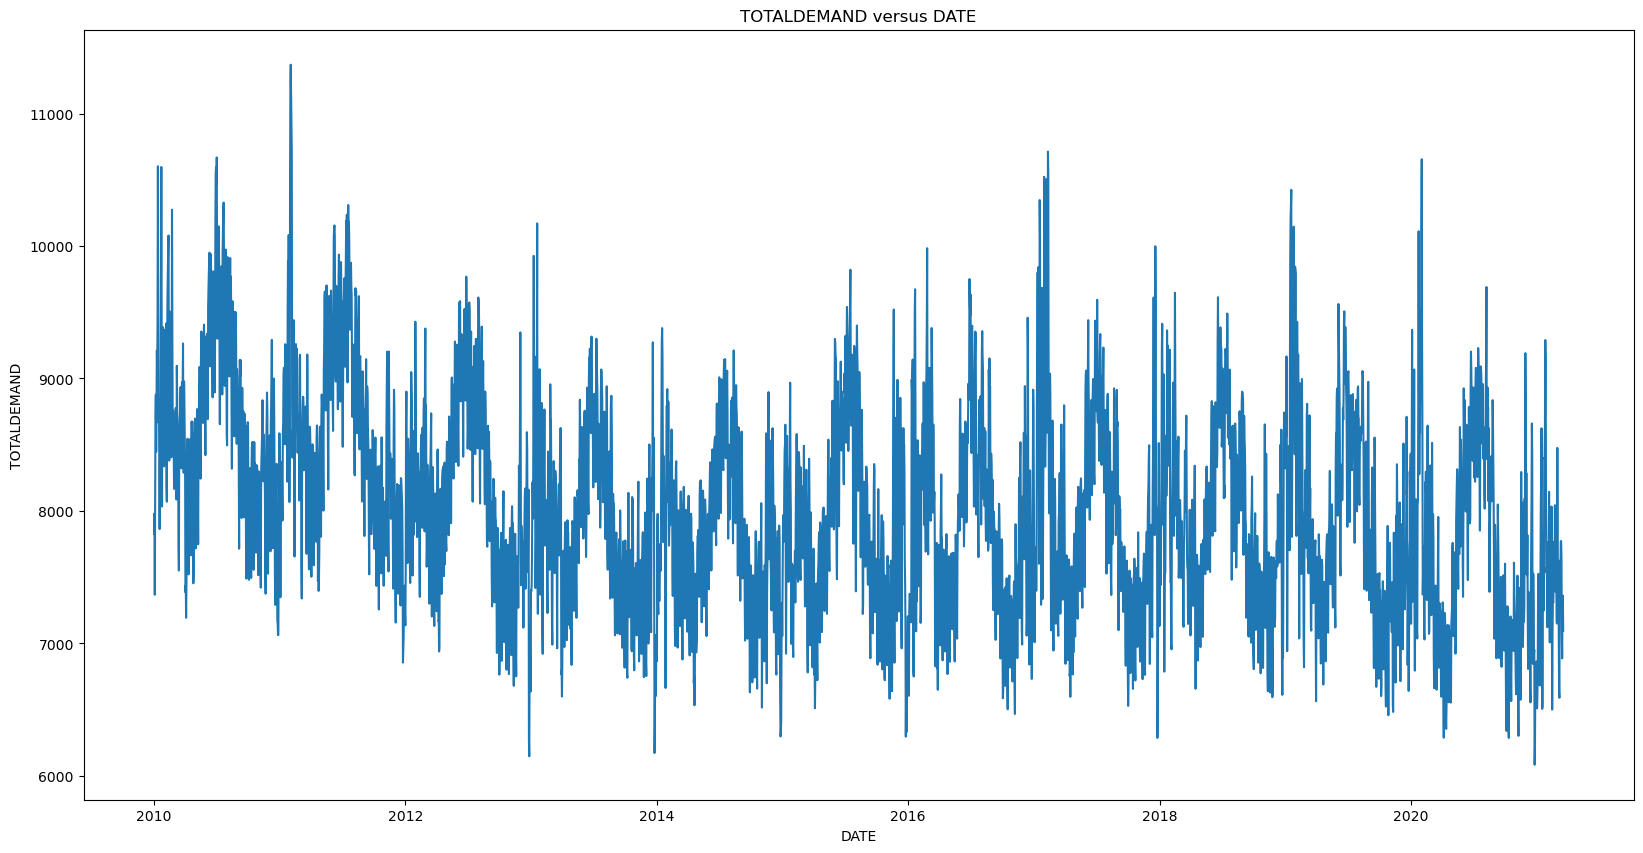

In [111]:
#create a new df where the TOTALDEMAND is averaged by the day and then graphed against the DATE
df_date = df

#extract the date from the DATETIME column
df_date['DATE'] = df['DATETIME'].dt.date

#group by the DATE column and average the TOTALDEMAND
df_date = df.groupby('DATE').mean().reset_index()

#drop the DATETIME and PERIODID columns
df_date.drop(['DATETIME', 'PERIODID'], axis=1, inplace=True)



print(df_date.head())

#graph the FORECASTDEMAND versus DATETIME
plt.figure(figsize=(20,10))
plt.plot(df_date['DATE'], df_date['TOTALDEMAND'])
plt.xlabel('DATE')
plt.ylabel('TOTALDEMAND')
plt.title('TOTALDEMAND versus DATE')
plt.show()



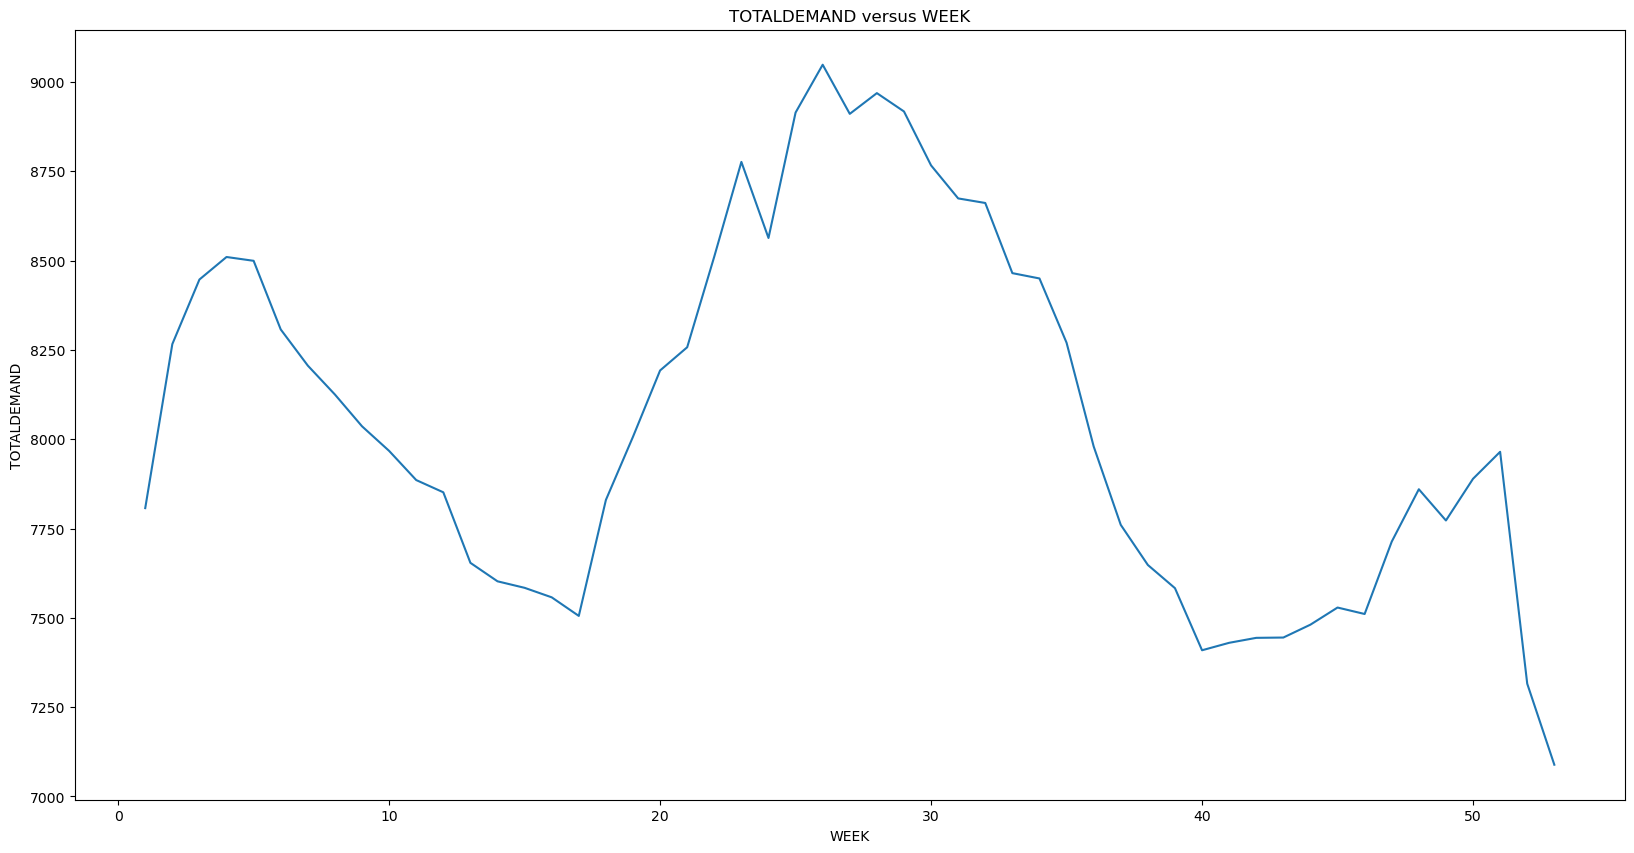

In [117]:
#create a new df where the TOTALDEMAND is averaged by the week within each year and then graphed against the DATE
df_week = df

#extract the week from the DATETIME column
df_week1 = df_week['DATETIME'].dt.isocalendar()
df_week['WEEK'] = df_week1['week']
df_week['YEAR'] = df_week1['year']

#drop DATETIME and REGIONID columns
df_week = df_week.drop(['DATETIME','PERIODID','DATE'], axis=1)

#group by the WEEK and YEAR columns and average the TOTALDEMAND
df_week = df_week.groupby(['YEAR', 'WEEK']).mean().reset_index()

#Average the TOTALDEMAND by the week within each year
df_week = df_week.groupby(['WEEK']).mean().reset_index()

#graph TOTALDEMAND versus WEEK
plt.figure(figsize=(20,10))
plt.plot(df_week['WEEK'], df_week['TOTALDEMAND'])
plt.xlabel('WEEK')
plt.ylabel('TOTALDEMAND')
plt.title('TOTALDEMAND versus WEEK')
plt.show()




In [63]:
import statsmodels.api as sm
from statsmodels.api import OLS

